In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
import scipy
params = {"xtick.labelsize" : 18,
          "ytick.labelsize":18,
          "axes.titlesize":18,
          "axes.labelsize":20,
          "legend.fontsize":18,
          "legend.title_fontsize":22,
          "figure.titlesize": 24
          }
pylab.rcParams.update(params)

Loading The Dataset

In [2]:
!rm *.csv

from google.colab import files
print("Please load the raw csv data")
uploadedData = files.upload()
filename = list(uploadedData)[0]

rm: cannot remove '*.csv': No such file or directory
Please load the raw csv data


Saving virus_data.csv to virus_data.csv


In [3]:
dataset = pd.read_csv(filename)

In [4]:
#Q1 - Shape of Data
num_rows, num_col = dataset.shape
print(f"there are {num_rows} rows and {num_col} columns")

there are 1250 rows and 25 columns


In [5]:
#Q2 - Conversations Value counts
dataset["conversations_per_day"].value_counts()

conversations_per_day
3     218
2     204
5     179
4     168
1     108
6     107
7      94
8      54
9      42
10     29
11     16
13      8
12      7
14      6
16      5
15      3
17      1
29      1
Name: count, dtype: int64

In [6]:
#Q3 - All data columns
dataset.columns

Index(['patient_id', 'age', 'sex', 'weight', 'blood_type', 'current_location',
       'num_of_siblings', 'happiness_score', 'household_income',
       'conversations_per_day', 'sugar_levels', 'sport_activity', 'pcr_date',
       'PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05', 'PCR_06', 'PCR_07',
       'PCR_08', 'PCR_09', 'PCR_10', 'spread', 'risk'],
      dtype='object')

In [7]:
from sklearn.model_selection import train_test_split
#Q4 - train-test splitting
df_train, df_test = train_test_split(dataset, train_size=0.8, random_state=74+40)

In [8]:
print(df_train.shape)
print(df_test.shape)

(1000, 25)
(250, 25)


In [9]:
#Q5 - Get features with missing values
def get_features_with_missing_values(df, df_type):
  features_with_missing_values = []
  for feature in df.columns:
    num_of_missing_values_in_col = df[feature].isna().sum()
    if(num_of_missing_values_in_col > 0):
      features_with_missing_values.append(feature)
      print(f"feature {feature} in {df_type} set has {num_of_missing_values_in_col} missing values")
  return features_with_missing_values

# find all features with missing values in the *train* set
train_set_features_with_missing_value = get_features_with_missing_values(df_train, "train")

# find all features with missing values in the *test* set
test_set_features_with_missing_value = get_features_with_missing_values(df_test, "test")

feature household_income in train set has 87 missing values
feature household_income in test set has 22 missing values


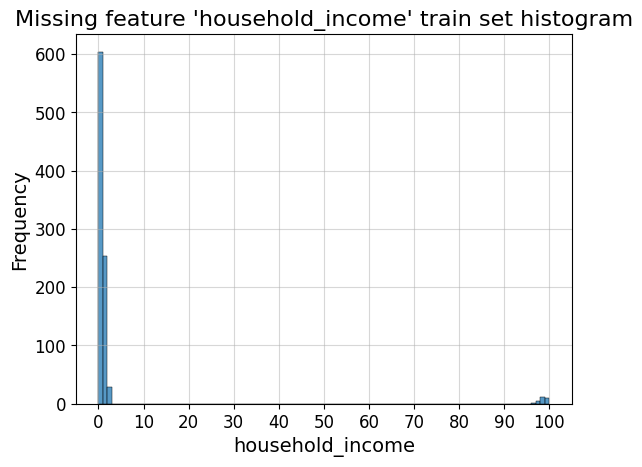

In [10]:
#Q6 - plot a histogram for every feature with missing values in the train set
for feature in train_set_features_with_missing_value:
  ax = sns.histplot(df_train[feature], bins=100, kde=False)
  ax.set_title(f"Missing feature '{feature}' train set histogram", fontsize=16)
  ax.set_xlabel(feature, fontsize=14)
  ax.set_ylabel('Frequency', fontsize=14)
  ax.tick_params(axis='both', which='major', labelsize=12)
  x_ticks = np.arange(0, df_train[feature].max() + 1, 10)
  plt.xticks(x_ticks)
  ax.grid(alpha=0.5)
  plt.show()

In [11]:
#Q7 - calculate the mean and median for every missing feature in the train set
for feature in train_set_features_with_missing_value:
  print(f"feature {feature} mean is: {df_train[feature].mean()}, median is: {df_train[feature].median()}")

feature household_income mean is: 3.641621029572837, median is: 0.7


In [12]:
##TASK A - Fix Missing values in train & test
original_df_train = df_train.copy()

def fill_missing_values(df, features_with_missing_value):
  for feature in features_with_missing_value:
    median = original_df_train[feature].median()
    print(f"Replacing NA in {feature} with the median: {median}")
    df[feature] = df[feature].fillna(median)
    print(f"feature {feature} has {df[feature].isna().sum()} missing values")

fill_missing_values(df_train, train_set_features_with_missing_value)
fill_missing_values(df_test, test_set_features_with_missing_value)

Replacing NA in household_income with the median: 0.7
feature household_income has 0 missing values
Replacing NA in household_income with the median: 0.7
feature household_income has 0 missing values


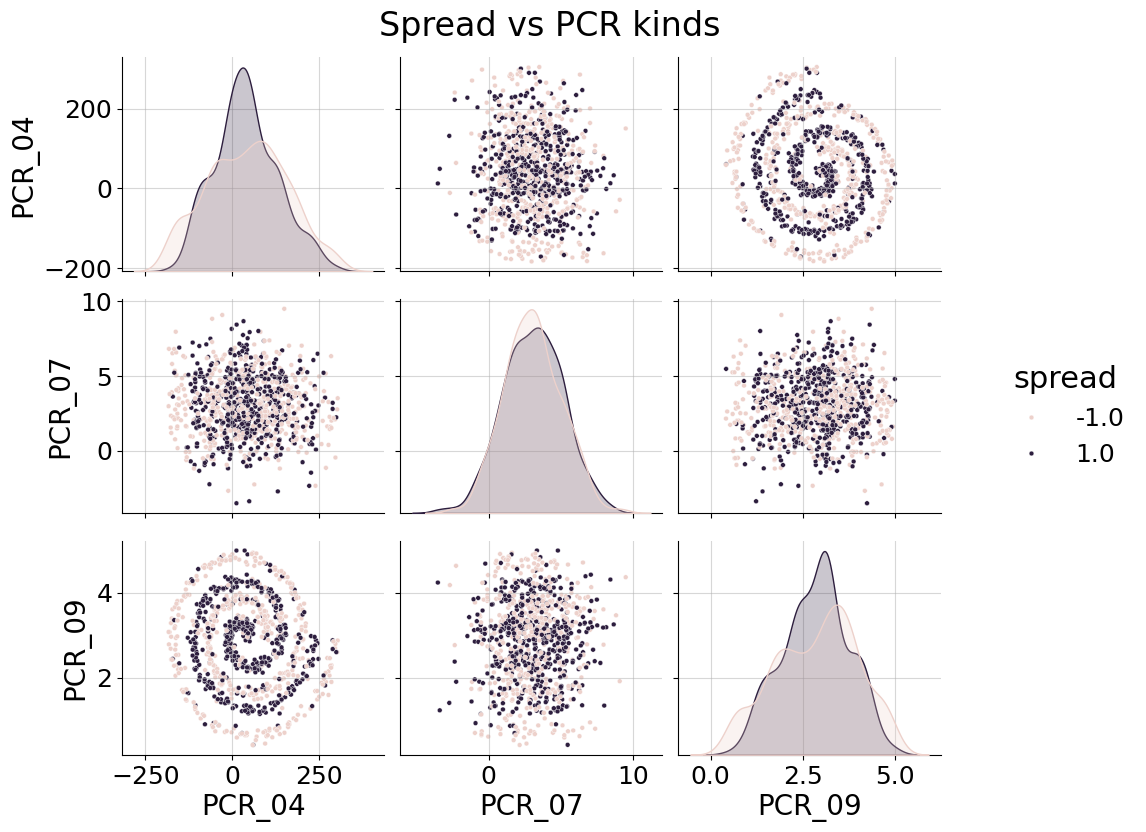

In [13]:
##TASK B - Spread vs PCR pair-plots
g = sns.pairplot(df_train, hue="spread", vars=["PCR_04" , "PCR_07" , "PCR_09"], plot_kws={'s': 12})
g.fig.suptitle("Spread vs PCR kinds", y=1.04)

for ax in np.ravel(g.axes):
  ax.grid(alpha=0.5)

g.fig.set_size_inches(12,8)

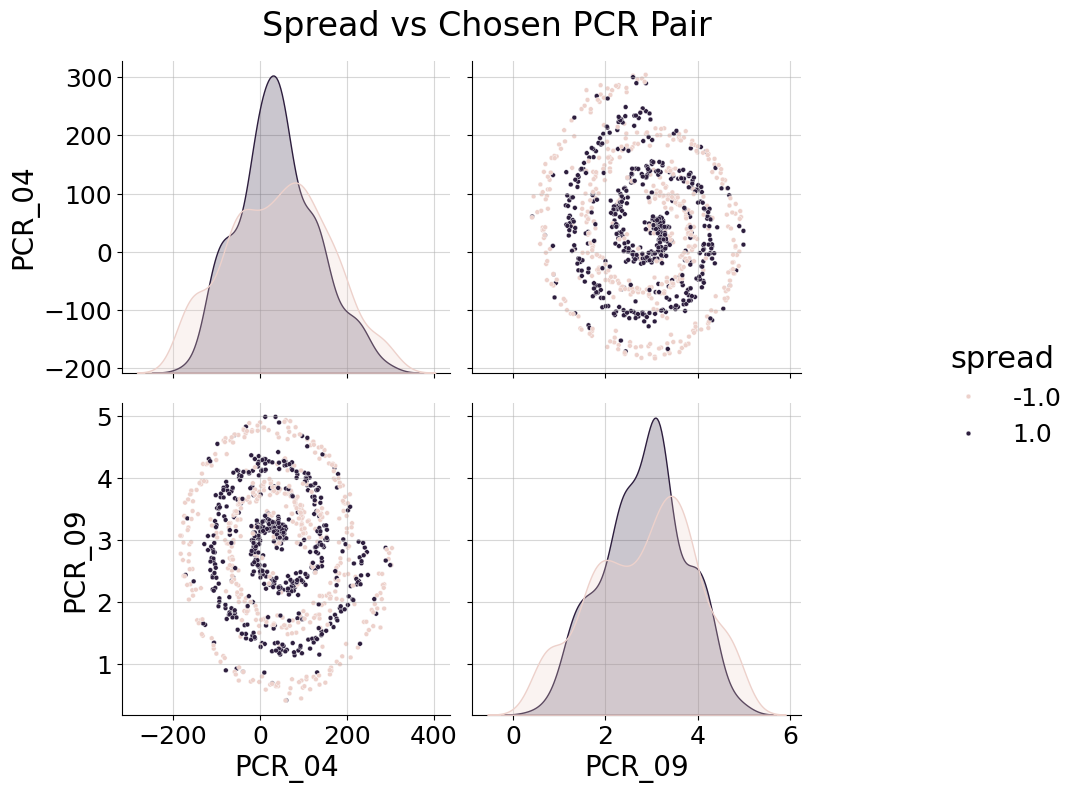

In [14]:
##TASK B - plot for the chosen pair only
g = sns.pairplot(df_train, hue="spread", vars=["PCR_04", "PCR_09"], plot_kws={'s': 12})
g.fig.suptitle("Spread vs Chosen PCR Pair", y=1.04)

for ax in np.ravel(g.axes):
  ax.grid(alpha=0.5)

g.fig.set_size_inches(12,8)

In [15]:
##TASK C - kNN implementation
from sklearn.base import BaseEstimator, ClassifierMixin

class kNN(BaseEstimator, ClassifierMixin):
  def __init__(self, n_neighbors:int = 3):
    self.n_neighbors = n_neighbors

  def fit(self, X, y):
    self.X = np.copy(X)
    self.y = np.copy(y)

  def predict(self, X):
    distances = scipy.spatial.distance.cdist(X, self.X)
    arg_neighbors = np.argpartition(distances, self.n_neighbors, axis=1)
    label_of_neighbors = self.y[arg_neighbors[:,:self.n_neighbors]]
    predictions = np.sign(np.sum(label_of_neighbors, axis=1))
    return predictions

In [16]:
##TASK D - kNN fitting
df_train_features_pair = df_train[["PCR_04", "PCR_09"]]
df_train_spread_labels = df_train["spread"]

df_test_features_pair = df_test[["PCR_04", "PCR_09"]]
df_test_spread_labels = df_test["spread"]

knn_model = kNN(n_neighbors=1)
knn_model.fit(df_train_features_pair, df_train_spread_labels)

In [17]:
def visualize_clf(clf, X, Y, title,
                  xlabel, ylabel,
                  marker_size=50,
                  grid_length=300,
                  linewidths=None):
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import ListedColormap

    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()

    # For internal use here, make sure labels are 0 and 1
    Y = np.ravel(Y).astype(int)
    labels = set(Y)
    assert len(labels) == 2, "Can only visualize two unique labels"

    if labels == set([-1,1]):
      Y = (Y + 1) // 2
      labels = set(Y)

    assert labels == set([0,1]), "Could not handle given labels"

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["D", "o"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                         np.linspace(y_min, y_max, grid_length))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(labels, palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size,
                    linewidths=linewidths)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()


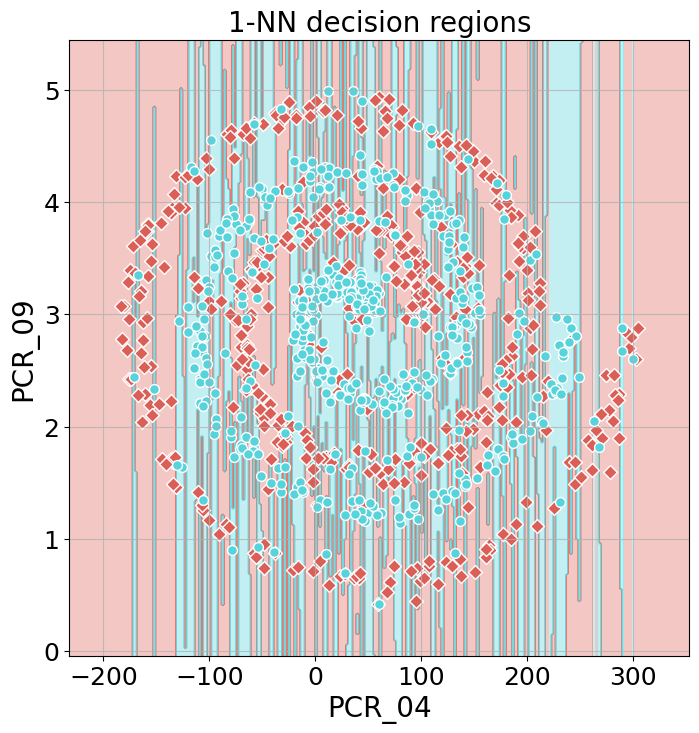

In [18]:
visualize_clf(knn_model, df_train_features_pair, df_train_spread_labels, title='1-NN decision regions', xlabel='PCR_04', ylabel='PCR_09')

In [19]:
#Q10 - kNN evaluation
train_acc = knn_model.score(df_train_features_pair, df_train_spread_labels)
print(f"train accuracy is: {train_acc*100}%")
test_acc = knn_model.score(df_test_features_pair, df_test_spread_labels)
print(f"test accuracy is: {test_acc*100}%")

train accuracy is: 100.0%
test accuracy is: 62.4%


In [20]:
#Q11 - normalize the features pair using MinMax scaling between [-1,1]
import sklearn

df_train_features_pair_normalized = df_train_features_pair.copy()
df_test_features_pair_normalized = df_test_features_pair.copy()

scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler.fit(df_train_features_pair_normalized) # ensure the min and max values are from the train set

# normalize the train set
df_train_features_pair_normalized[df_train_features_pair_normalized.columns] = scaler.transform(df_train_features_pair_normalized[df_train_features_pair_normalized.columns])
# normalize the test set
df_test_features_pair_normalized[df_test_features_pair_normalized.columns] = scaler.transform(df_test_features_pair_normalized[df_test_features_pair_normalized.columns])

train accuracy is: 100.0%
test accuracy is: 72.39999999999999%


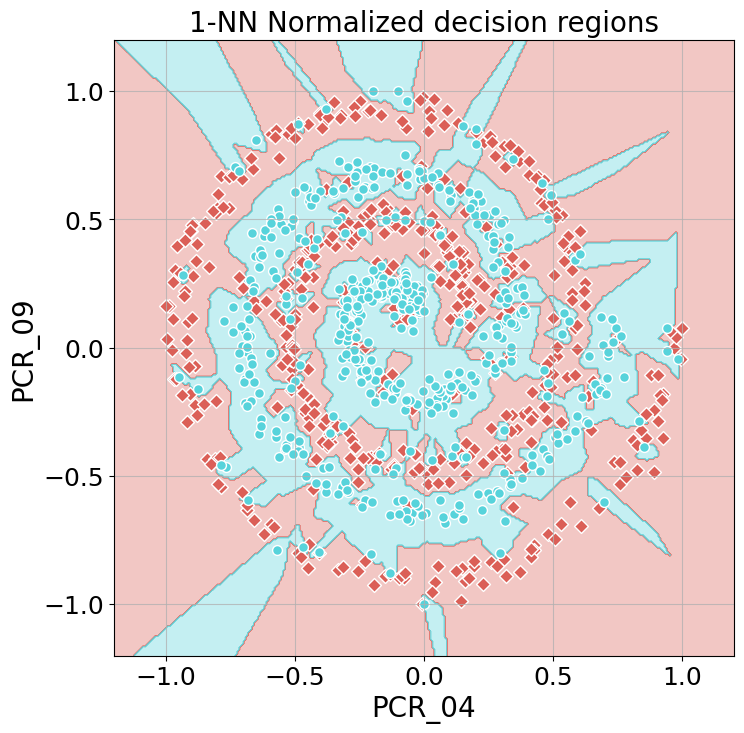

In [21]:
#Q11 - train 1-NN model with the normalized dataset
knn_model = kNN(n_neighbors=1)
knn_model.fit(df_train_features_pair_normalized, df_train_spread_labels)

train_acc = knn_model.score(df_train_features_pair_normalized, df_train_spread_labels)
print(f"train accuracy is: {train_acc*100}%")
test_acc = knn_model.score(df_test_features_pair_normalized, df_test_spread_labels)
print(f"test accuracy is: {test_acc*100}%")

visualize_clf(knn_model, df_train_features_pair_normalized, df_train_spread_labels, title='1-NN Normalized decision regions', xlabel='PCR_04', ylabel='PCR_09')

train accuracy is: 84.6%
test accuracy is: 80.4%


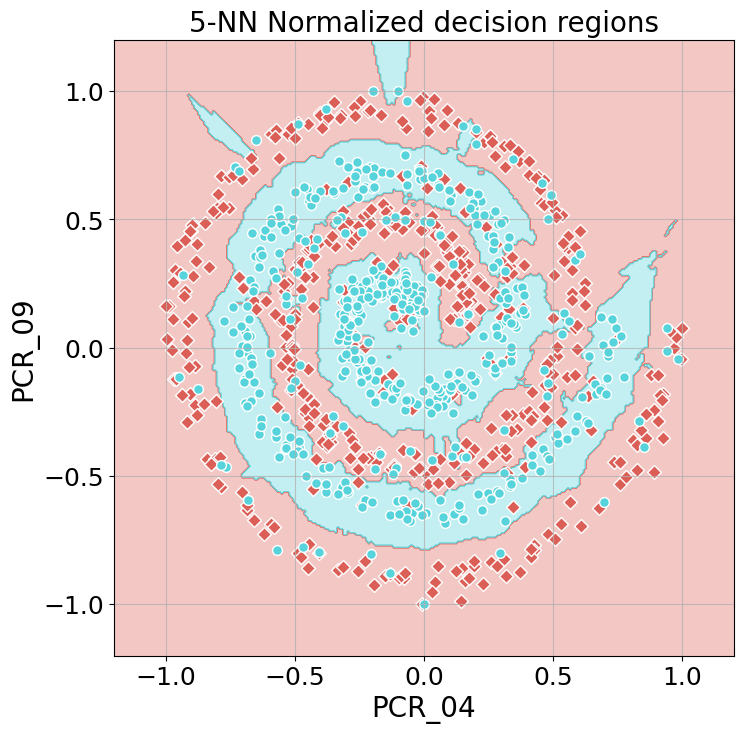

In [22]:
#Q12 - train 5-NN model with the normalized dataset
knn_model = kNN(n_neighbors=5)
knn_model.fit(df_train_features_pair_normalized, df_train_spread_labels)

train_acc = knn_model.score(df_train_features_pair_normalized, df_train_spread_labels)
print(f"train accuracy is: {train_acc*100}%")
test_acc = knn_model.score(df_test_features_pair_normalized, df_test_spread_labels)
print(f"test accuracy is: {test_acc*100}%")

visualize_clf(knn_model, df_train_features_pair_normalized, df_train_spread_labels, title='5-NN Normalized decision regions', xlabel='PCR_04', ylabel='PCR_09')

In [23]:
#Part 4: Data Exploration
#Task E
df_train_blood = df_train.copy()
df_train_blood["SpecialProperty"] = df_train_blood["blood_type"].isin(["O+", "B+"])
df_train_blood = df_train_blood.drop("blood_type", axis=1)

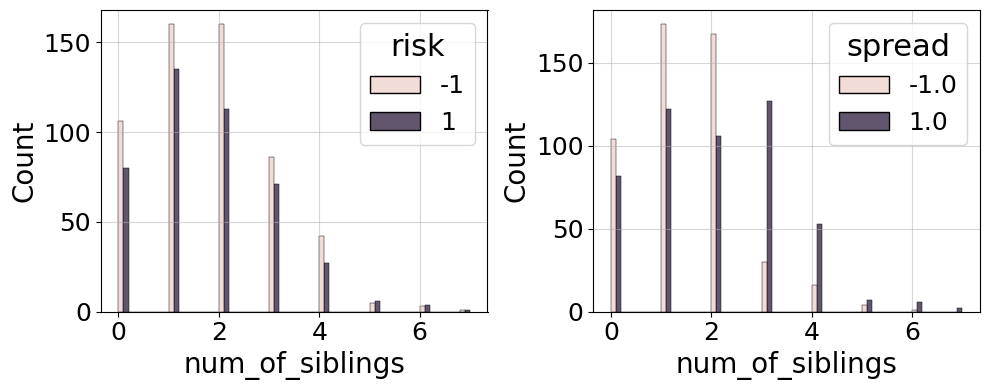

In [24]:
#Univariate
df_train = df_train_blood
COL_NAME = ["num_of_siblings"]
"""COL_NAME = ['age', 'sex', 'weight', 'SpecialProperty', 'current_location',
            'num_of_siblings', 'happiness_score', 'household_income',
            'conversations_per_day', 'sugar_levels', 'sport_activity',
            'pcr_date', 'PCR_01', 'PCR_02', 'PCR_03', 'PCR_05', 'PCR_06',
            'PCR_07', 'PCR_08', 'PCR_10']"""

COLS, ROWS = (2, len(COL_NAME))


plt.figure(figsize=(5 * COLS, 4 * ROWS))
for row in range(ROWS):
  column = COL_NAME[row]


  for j, cls in enumerate(["risk", "spread"]):
    plt.subplot(ROWS,COLS, row * COLS + 1 + j)

    isContinuous = "float" in df_train[column].dtype.name
    sns.histplot(data=df_train, x=column, hue=cls, line_kws={"linewidth": 3},
                 kde=isContinuous, multiple="layer" if isContinuous else "dodge")
    # plt.title(f"{column} vs {cls} Histogram")
    plt.grid(alpha=0.5)

plt.tight_layout()

In [25]:
def plot_PCR_pairs(df):
  sns.pairplot(df[df.filter(like="PCR").columns.tolist()+["risk"]], plot_kws={"s":3}, hue="risk")

Special


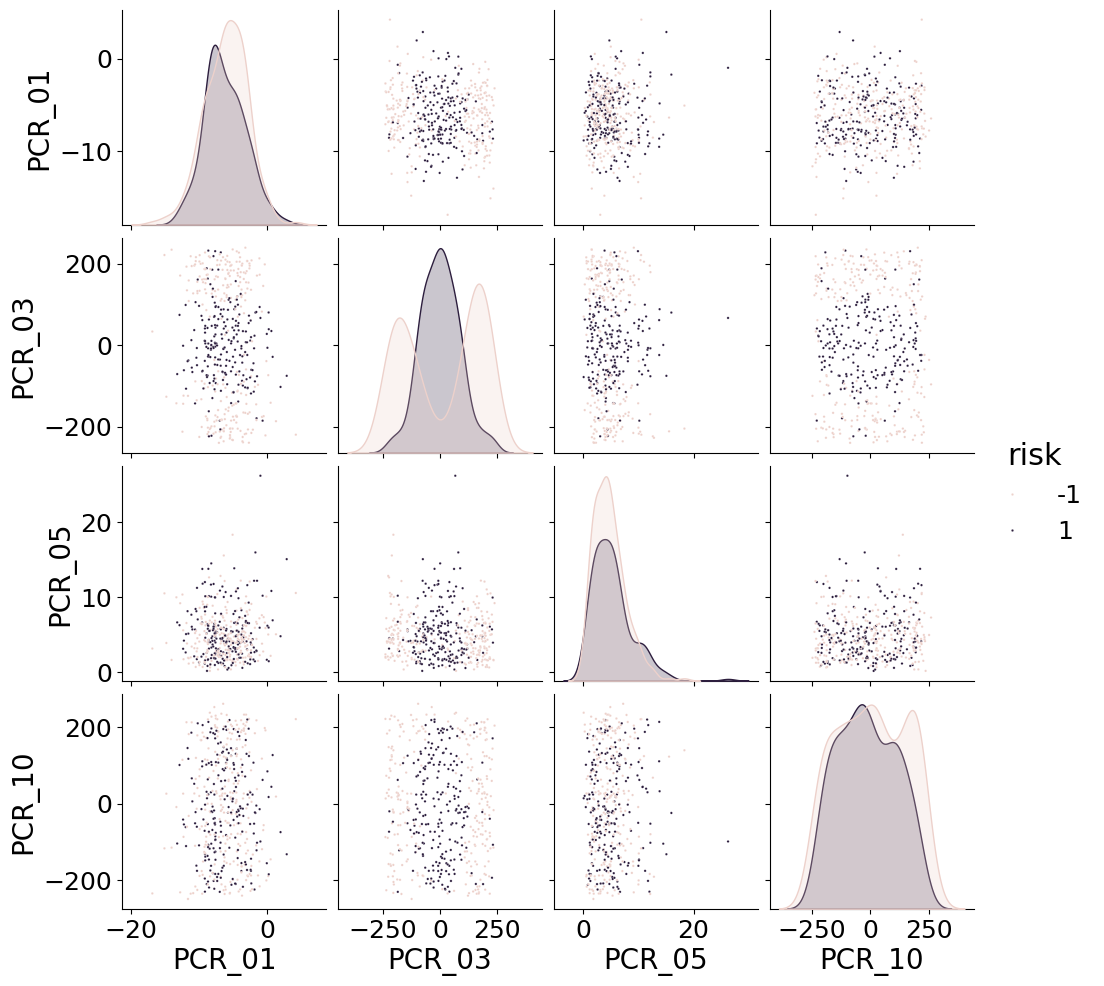

In [26]:
#Q16
df_train_special = df_train[df_train.SpecialProperty == True][["risk", "PCR_01", "PCR_03", "PCR_05", "PCR_10"]]
df_train_not_special = df_train[df_train.SpecialProperty != True][["risk", "PCR_01", "PCR_03", "PCR_05", "PCR_10"]]

print("Special")
plot_PCR_pairs(df_train_special)

Not Special


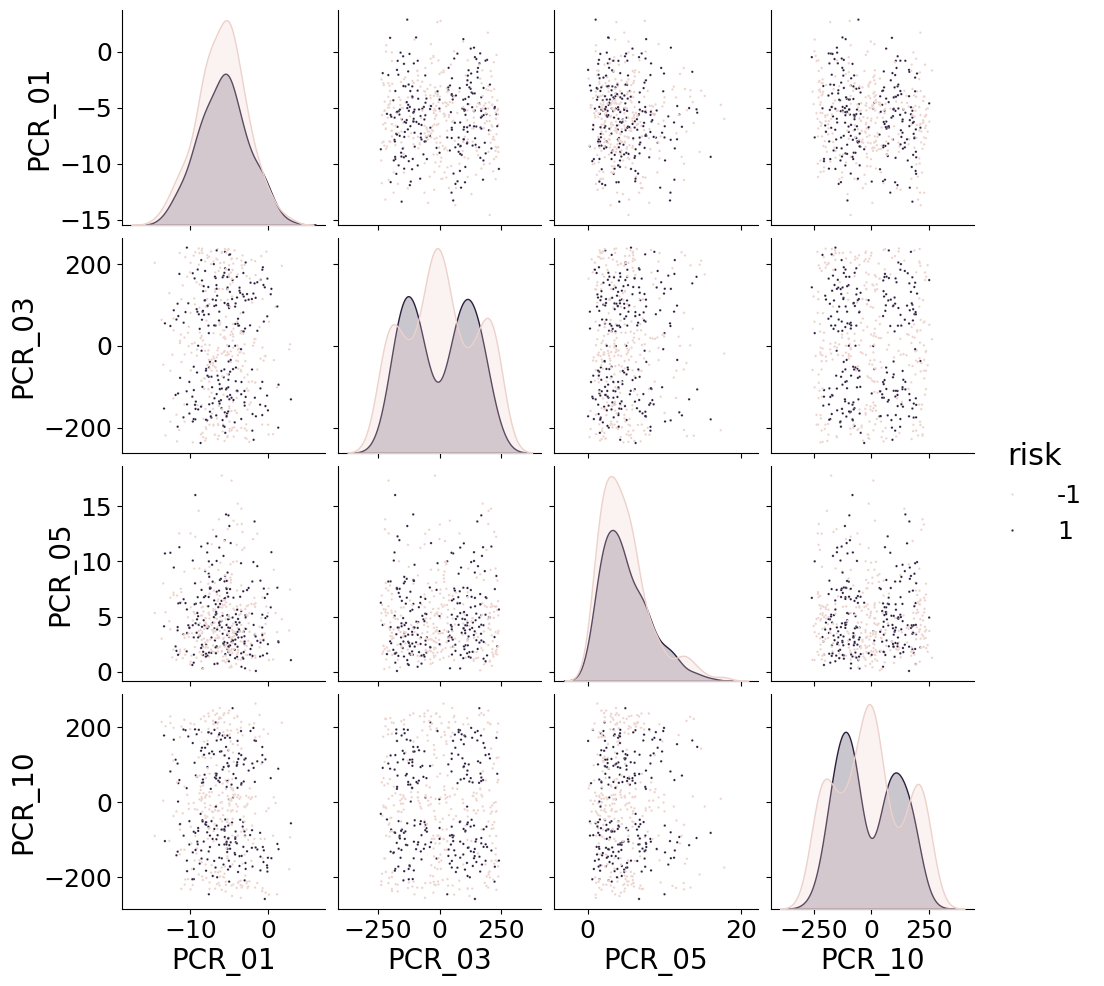

In [27]:
print("Not Special")
plot_PCR_pairs(df_train_not_special)

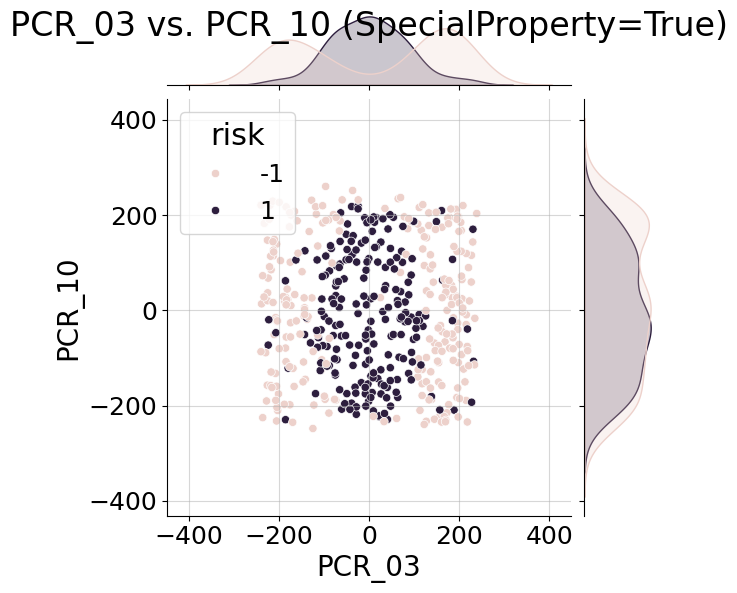

In [28]:
#Q17
g = sns.jointplot(data=df_train_special, x="PCR_03", y="PCR_10", kind="scatter", hue="risk")
_ = g.ax_joint.grid(alpha=0.5)
_ = g.fig.suptitle("PCR_03 vs. PCR_10 (SpecialProperty=True)")

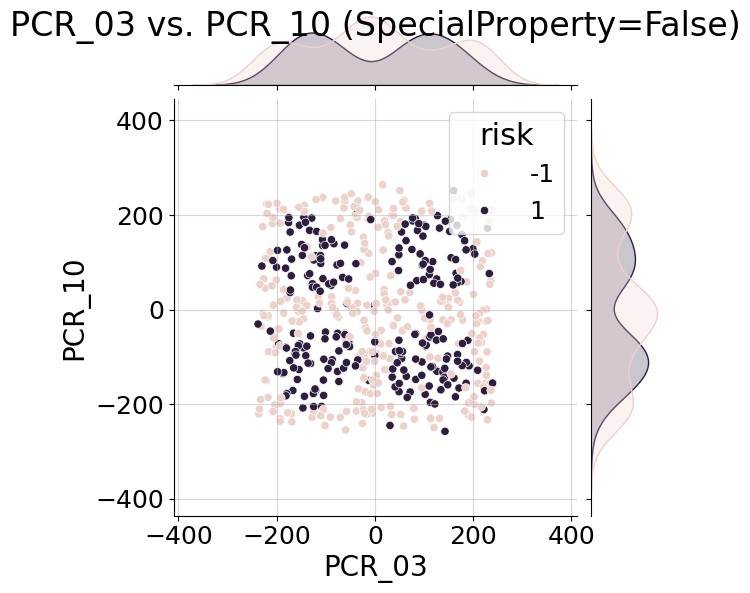

In [29]:
g = sns.jointplot(data=df_train_not_special, x="PCR_03", y="PCR_10", kind="scatter", hue="risk")
_ = g.ax_joint.grid(alpha=0.5)
_ = g.fig.suptitle("PCR_03 vs. PCR_10 (SpecialProperty=False)")

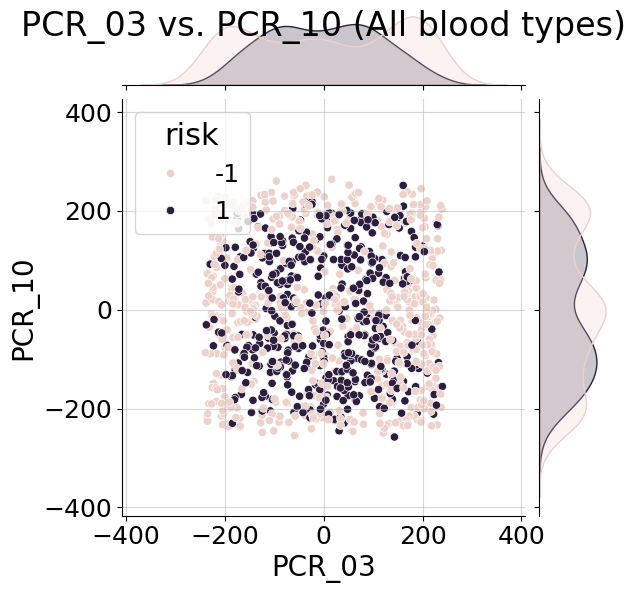

In [30]:
g = sns.jointplot(data=df_train, x="PCR_03", y="PCR_10", kind="scatter", hue="risk")
_ = g.ax_joint.grid(alpha=0.5)
_ = g.fig.suptitle("PCR_03 vs. PCR_10 (All blood types)")

In [31]:
def plot3d(df, colX, colY, colZ, title, hue=None, s=1):
  %matplotlib inline

  fig = plt.figure(figsize=(20, 4))
  axes = [fig.add_subplot(1, 4, 1, projection='3d'),
          fig.add_subplot(1, 4, 2, projection='3d'),
          fig.add_subplot(1, 4, 3, projection='3d'),
          fig.add_subplot(1, 4, 4, projection='3d')]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if hue is None:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=s)
    else:
      idx = df[hue] == True
      df1 = df[idx]
      df2 = df[~idx]

      ax.scatter3D(df1[colX], df1[colY], df1[colZ], color=palette[0], s=s)
      ax.scatter3D(df2[colX], df2[colY], df2[colZ], color=palette[1], s=s)

    if i == 3 or i == 1:
      ax.set_xlabel(colX, labelpad=20)
      ax.set_ylabel(colY, labelpad=20)
    else:
      ax.xaxis.set_ticklabels([])
      ax.yaxis.set_ticklabels([])

    ax.view_init(elev=5., azim=45*i+15)

  axes[1].set_zlabel("\n" + colZ, labelpad=1)

  plt.suptitle(title)
  plt.subplots_adjust(wspace=0.1, top=0.99)
  plt.show()

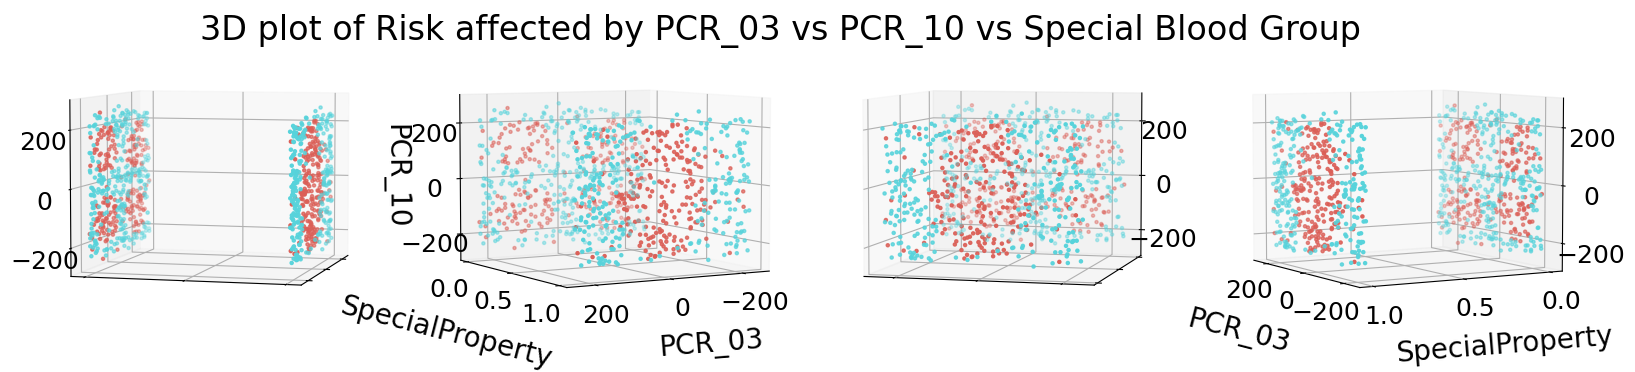

In [32]:
#Q18
plot3d(df_train, "PCR_03", "SpecialProperty", "PCR_10", title="3D plot of Risk affected by PCR_03 vs PCR_10 vs Special Blood Group", hue="risk", s=5)

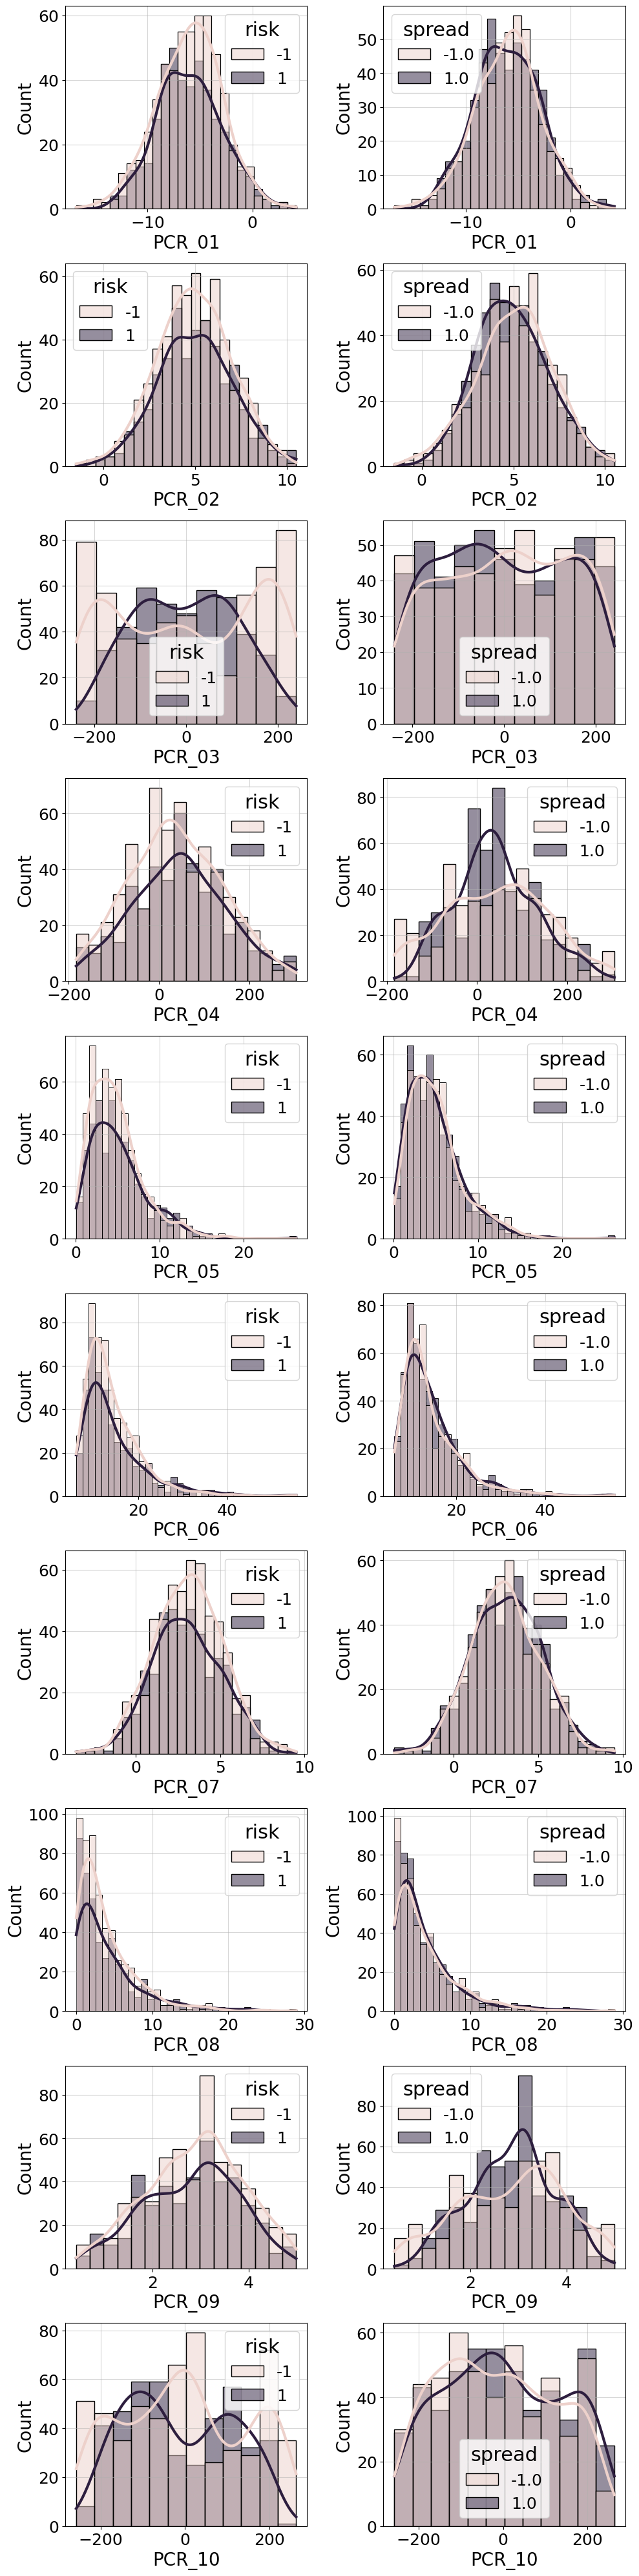

In [33]:
#Task F
#Univariate
df_train = df_train_blood
COL_NAME = ['PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05', 'PCR_06', 'PCR_07', 'PCR_08', 'PCR_09', 'PCR_10']
"""COL_NAME = ['patient_id', 'age', 'sex', 'weight', 'SpecialProperty', 'current_location',
            'num_of_siblings', 'happiness_score', 'household_income',
            'conversations_per_day', 'sugar_levels', 'sport_activity', 'pcr_date']"""
COLS, ROWS = (2, len(COL_NAME))


plt.figure(figsize=(5 * COLS, 4 * ROWS))
for row in range(ROWS):
  column = COL_NAME[row]


  for j, cls in enumerate(["risk", "spread"]):
    plt.subplot(ROWS,COLS, row * COLS + 1 + j)

    isContinuous = "float" in df_train[column].dtype.name
    sns.histplot(data=df_train, x=column, hue=cls, line_kws={"linewidth": 3},
                 kde=isContinuous, multiple="layer" if isContinuous else "dodge")
    plt.grid(alpha=0.5)


plt.tight_layout()


In [34]:
def StandardNormalize(df, df_new, columns):
  scaler = sklearn.preprocessing.StandardScaler()
  scaler.fit(df[columns])
  df_new[columns] = scaler.transform(df_new[columns])

def MinMaxNormalize(df, df_new, columns):
  scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
  scaler.fit(df[columns])
  df_new[columns] = scaler.transform(df_new[columns])


StandardNormalize(df_train, df_train, ["PCR_01", "PCR_02", "PCR_05", "PCR_06", "PCR_07", "PCR_08"])
MinMaxNormalize(df_train, df_train, ["PCR_10", "PCR_03", "PCR_04", "PCR_09"])

df_train.head()

,patient_id,age,sex,weight,current_location,num_of_siblings,happiness_score,household_income,conversations_per_day,sugar_levels,...,PCR_04,PCR_05,PCR_06,PCR_07,PCR_08,PCR_09,PCR_10,spread,risk,SpecialProperty
1003,525,32,F,61.7,"('39.46667', '141.95')",3,6,0.0,5,76,...,0.252362,0.229857,0.564941,-0.941701,-0.851311,0.822201,-0.766946,-1.0,-1,False
1186,999,13,M,51.8,"('43.41949', '77.0202')",3,11,0.7,3,93,...,-0.074230,-0.828549,-0.157873,1.153566,-0.447237,0.296585,-0.193895,1.0,1,False
299,543,5,M,40.0,"('19.32932', '-98.1664')",2,11,0.7,1,93,...,0.122425,2.264492,-0.386339,-0.034835,-0.430950,-0.164739,-0.354583,-1.0,-1,False
628,751,15,F,48.3,"('18.18158', '76.03889')",3,11,0.3,5,87,...,-0.027231,1.823033,-0.698029,1.568307,0.184773,-0.219594,-0.317438,1.0,1,False
812,335,10,F,29.6,"('47.05', '15.46667')",2,6,0.4,3,47,...,-0.561522,-0.458640,0.623288,0.058180,-0.348073,0.737295,-0.385646,-1.0,-1,False


In [35]:
def prep_locations(prepared_data):
  locations = prepared_data["current_location"].values

  longitudes = np.zeros(len(locations))
  latitudes = np.zeros(len(locations))
  for i in range(len(locations)):
    longitudes[i], latitudes[i] = locations[i].split(",")[0][2:-2], locations[i].split(",")[1][2:-2]
  prepared_data["longitude"] = longitudes
  prepared_data["latitude"] = latitudes
  prepared_data = prepared_data.drop("current_location", axis=1)

import datetime

def date_to_timestamp(date_str): #2021-12-18
  date = datetime.datetime(int(date_str[:4]), int(date_str[5:7]), int(date_str[8:10]))
  return date.timestamp()

def prep_dates(prepared_data):
  dates = prepared_data["pcr_date"].values

  dates_num = np.zeros(len(dates))

  for i in range(len(dates)):
    dates_num[i] = date_to_timestamp(dates[i])
  prepared_data["pcr_date_timestamp"] = dates_num
  prepared_data = prepared_data.drop("pcr_date", axis=1)

In [36]:
def prepare_data(training_data, new_data):
  prepared_data = new_data.copy()
  training_data_copy = training_data.copy()

  #Remove Patient Id
  prepared_data = prepared_data.drop("patient_id", axis=1)

  #Replace NaN values for household_income:
  median = training_data["household_income"].median()
  prepared_data["household_income"] = prepared_data["household_income"].fillna(median)

  #Prepare Blood Types
  prepared_data["SpecialProperty"] = prepared_data["blood_type"].isin(["O+", "B+"])
  prepared_data = prepared_data.drop("blood_type", axis=1)

  #Prepare Longitude and Latitude
  prep_locations(prepared_data)
  prep_locations(training_data_copy)

  #Prepare Date:
  prep_dates(prepared_data)
  prep_dates(training_data_copy)

  #Normalization
  StandardNormalize(training_data_copy, prepared_data, ["PCR_01", "PCR_02", "PCR_05", "PCR_06", "PCR_07", "PCR_08", "age", "weight", "num_of_siblings", "happiness_score", "conversations_per_day", "household_income","sugar_levels", "longitude"])
  MinMaxNormalize(training_data_copy, prepared_data, ["PCR_10", "PCR_03", "PCR_04", "PCR_09", "sport_activity", "latitude", "pcr_date_timestamp"])
  return prepared_data

In [37]:
#Reset all other preparations:
df_train, df_test = train_test_split(dataset, train_size=0.8, random_state=74+40)

# Prepare training set according to itself
train_df_prepared = prepare_data(df_train, df_train)

# Prepare test set according to the raw training set
test_df_prepared = prepare_data(df_train, df_test)

train_df_prepared.head()

,age,sex,weight,current_location,num_of_siblings,happiness_score,household_income,conversations_per_day,sugar_levels,sport_activity,...,PCR_07,PCR_08,PCR_09,PCR_10,spread,risk,SpecialProperty,longitude,latitude,pcr_date_timestamp
1003,0.342339,F,0.159423,"('39.46667', '141.95')",1.015168,-2.123477,-0.219570,0.120837,-0.713155,-0.2,...,-0.941701,-0.851311,0.822201,-0.766946,-1.0,-1,False,0.428958,0.784416,-0.031724
1186,-0.928806,M,-0.348163,"('43.41949', '77.0202')",1.015168,1.422744,-0.177364,-0.559933,0.284593,-0.6,...,1.153566,-0.447237,0.296585,-0.193895,1.0,1,False,0.606350,0.396171,-0.051034
299,-1.464025,M,-0.953165,"('19.32932', '-98.1664')",0.234870,1.422744,-0.177364,-1.240702,0.284593,-1.0,...,-0.034835,-0.430950,-0.164739,-0.354583,-1.0,-1,False,-0.474752,-0.651350,0.594483
628,-0.795001,F,-0.527613,"('18.18158', '76.03889')",1.015168,1.422744,-0.201481,0.120837,-0.067553,-0.6,...,1.568307,0.184773,-0.219594,-0.317438,1.0,1,False,-0.526262,0.390303,0.845517
812,-1.129513,F,-1.486387,"('47.05', '15.46667')",0.234870,-2.123477,-0.195452,-0.559933,-2.415195,-1.0,...,0.058180,-0.348073,0.737295,-0.385646,-1.0,-1,False,0.767038,0.028114,0.804138


In [38]:
test_df_prepared.head()

,age,sex,weight,current_location,num_of_siblings,happiness_score,household_income,conversations_per_day,sugar_levels,sport_activity,...,PCR_07,PCR_08,PCR_09,PCR_10,spread,risk,SpecialProperty,longitude,latitude,pcr_date_timestamp
1013,-0.326684,F,0.062008,"('37.1759', '128.9889')",-0.545429,0.004255,-0.129128,-0.900318,0.871503,-1.0,...,-1.268583,-0.509367,-0.881339,-0.412536,-1.0,-1,True,0.326117,0.706915,0.009655
316,-0.661196,M,-0.337909,"('36.81667', '117.81667')",-0.545429,-0.704989,-0.219570,0.801606,0.519357,-1.0,...,-0.917617,-0.935069,-0.303026,-0.725822,-1.0,1,True,0.310033,0.640111,-0.097931
22,3.821263,F,0.195313,"('35.85', '117.7')",0.234870,-0.704989,-0.171334,1.822760,1.106268,-0.2,...,-0.987570,-0.320700,-0.241992,-0.777401,1.0,1,False,0.264411,0.639414,-0.095172
1081,0.074730,M,0.467051,"('24.05979', '77.40858')",-1.325727,-0.704989,-0.177364,-0.900318,-1.417447,-0.2,...,-2.839750,-0.752480,0.454118,0.985420,-1.0,-1,True,-0.262464,0.398493,0.313103
667,2.483216,M,1.087435,"('-19.32556', '-41.25528')",0.234870,0.713500,-0.171334,0.120837,0.167211,-1.0,...,-1.471164,-0.556747,0.222019,0.230766,-1.0,1,True,-2.209480,-0.311053,0.842759



Download From Colab

In [39]:
from google.colab import files
outputPath = "train_prepared.csv"
train_df_prepared.to_csv(outputPath)
files.download(outputPath)

outputPath = "test_prepared.csv"
test_df_prepared.to_csv(outputPath)
files.download(outputPath)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>